In [1]:
import numpy as np
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, QuantumRegister, transpile, Aer, IBMQ, execute
from qiskit.quantum_info import Operator, partial_trace
from qiskit.providers.ibmq import least_busy
from qiskit.tools.jupyter import *
from qiskit.visualization import *

# Loading your IBM Q account(s)
#IBMQ.save_account('a32b02193ca40f441c315c469b98d0ccd74e2093d6e74fe0e9c97d7413a824e85a4a7b09accbecde5a7ff10d8c033c9e9dfbc39f0c62441ee594d34a608ac268')

provider = IBMQ.load_account()

In [2]:
def phase_oracle(n, indices_to_make, name='Magic'):
    qc = QuantumCircuit(n,name=name)
    matx =np.identity(2**n)
    for index in indices_to_make:
        matx[index,index]=-1
    qc.unitary(Operator(matx),range(n))
    qc.draw()
    return qc


def diffuser(n):
    qc = QuantumCircuit(n,name='Diff')
    qc.h(range(n))
    qc.append(phase_oracle(n,[0]),range(n))
    qc.h(range(n))
    qc.draw()
    return qc

# big ball of wibbly-wobbly, timey-wimey
def something(n,marked):
    qc = QuantumCircuit(n, n)
    print(f'{n} qubits, basis state {marked} marked')
    qc.h(range(n))
    qc.append(phase_oracle(n,marked),range(n))
    qc.append(diffuser(n),range(n))
    
    qc.measure(range(n),range(n))
    return qc

In [3]:
n=5
x=np.random.randint(20)
marked=[x]
qc=something(n,marked)

qc.draw()

5 qubits, basis state [2] marked


┌───┐┌────────┐┌───────┐┌─┐            
q_0: ┤ H ├┤0       ├┤0      ├┤M├────────────
     ├───┤│        ││       │└╥┘┌─┐         
q_1: ┤ H ├┤1       ├┤1      ├─╫─┤M├─────────
     ├───┤│        ││       │ ║ └╥┘┌─┐      
q_2: ┤ H ├┤2 Magic ├┤2 Diff ├─╫──╫─┤M├──────
     ├───┤│        ││       │ ║  ║ └╥┘┌─┐   
q_3: ┤ H ├┤3       ├┤3      ├─╫──╫──╫─┤M├───
     ├───┤│        ││       │ ║  ║  ║ └╥┘┌─┐
q_4: ┤ H ├┤4       ├┤4      ├─╫──╫──╫──╫─┤M├
     └───┘└────────┘└───────┘ ║  ║  ║  ║ └╥┘
c: 5/═════════════════════════╩══╩══╩══╩══╩═
                              0  1  2  3  4

{'00000': 54, '00001': 43, '10000': 65, '10001': 45, '10010': 59, '10011': 48, '10100': 49, '10101': 52, '10110': 42, '10111': 42, '11000': 62, '11001': 48, '11010': 54, '11011': 37, '11100': 52, '11101': 51, '11110': 35, '11111': 36, '00010': 529, '00011': 50, '00100': 53, '00101': 53, '00110': 51, '00111': 44, '01000': 43, '01001': 50, '01010': 44, '01011': 61, '01100': 40, '01101': 45, '01110': 52, '01111': 59}


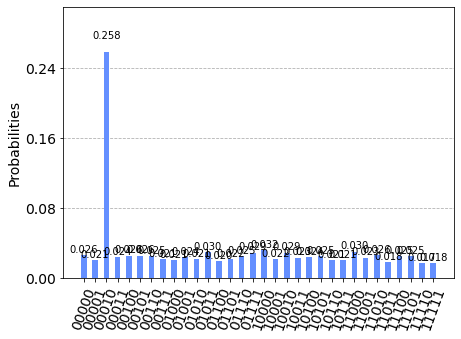

In [4]:
back = Aer.get_backend('qasm_simulator')
result = execute(qc,back,shots=2048).result()
counts = result.get_counts(qc)
print(counts)

plot_histogram(counts)

In [5]:
def live(nh):
    v=nh
    a=0
    for i in [0,2]:
        a+=(v[1][1][i]+v[i][1][1]+v[1][i][1])/2
    for i in [0,2]:
        a+=(v[0][i][0]+v[0][i][2]+v[2][i][0]+v[2][i][2])/8
    a+=(v[1][0][0]+v[1][2][2]+v[1][2][0]+v[1][0][2]+v[0][0][1]+v[0][1][0]+v[0][1][2]+v[0][2][1]+v[2][0][1]+v[2][1][0]+v[2][1][2]+v[2][2][1])/4
    return a

def gol(nh):
    a=live(nh)
    
    value=nh[1][1][1]
    alive = np.array([1.0,0.0])
    dead = np.array([0.0,1.0])
    B = np.array([[0,0],[1,1]])
    D = np.array([[1,1],[0,0]])
    S = np.array([[1,0],[0,1]])
    
    if a <= 1:
        value =  dead
    elif (a > 1 and a <= 3):
        value = ((np.sqrt(2)+1)*2-(np.sqrt(2)+1)*a)*dead+(a-1)*value#(((np.sqrt(2)+1)*(2-a))**2+(a-1)**2)
    elif (a > 3 and a <= 4):
        value = (((np.sqrt(2)+1)*3)-(np.sqrt(2)+1)*a)*value+(a-2)*alive#(((np.sqrt(2)+1)*(3-a))**2+(a-2)**2)
    elif (a > 4 and a < 5):
        value = ((np.sqrt(2)+1)*4-(np.sqrt(2)+1)*a)*alive+(a-3)*dead#(((np.sqrt(2)+1)*(4-a))**2+(a-3)**2)
    elif a >= 5:
        value = dead
    
    value = value/np.linalg.norm(value)
    a=a/8
    a = a/np.linalg.norm(a)
    qr = QuantumRegister(5)
    qc = QuantumCircuit(qr,name='Morpheous')
    qc.initialize([a,0],[qr[0]])
    qc.initialize(value,[qr[1]])
    qc.initialize(value,[qr[2]])
    qc.cx(qr[0],qr[2])
    qc.cx(qr[1],qr[3])
    qc.cx(qr[2],qr[4])
    qc.cx(qr[4],qr[1])
    
    qc.barrier()
    qc.append(diffuser(5),range(5))
    qc.append(something(5,[int(a)]),range(5))
    
    back = Aer.get_backend('qasm_simulator')
    print(qc.draw())
    #result = execute(qc,back,shots=1).result()
    #counts = result.get_counts(qc)
    return qc
    return value


In [6]:
t=np.random.rand(3,3,3)


In [7]:
qc=gol(t)

5 qubits, basis state [1] marked
            ┌─────────────────┐                            ░ ┌───────┐»
q3_0: ──────┤ initialize(1,0) ├─────────■──────────────────░─┤0      ├»
      ┌─────┴─────────────────┴──────┐  │            ┌───┐ ░ │       │»
q3_1: ┤ initialize(0.60721,-0.79454) ├──┼────■───────┤ X ├─░─┤1      ├»
      ├──────────────────────────────┤┌─┴─┐  │       └─┬─┘ ░ │       │»
q3_2: ┤ initialize(0.60721,-0.79454) ├┤ X ├──┼────■────┼───░─┤2 Diff ├»
      └──────────────────────────────┘└───┘┌─┴─┐  │    │   ░ │       │»
q3_3: ─────────────────────────────────────┤ X ├──┼────┼───░─┤3      ├»
                                           └───┘┌─┴─┐  │   ░ │       │»
q3_4: ──────────────────────────────────────────┤ X ├──■───░─┤4      ├»
                                                └───┘      ░ └───────┘»
«      ┌────────────┐
«q3_0: ┤0           ├
«      │            │
«q3_1: ┤1           ├
«      │            │
«q3_2: ┤2 circuit96 ├
«      │            │
«q3_3: ┤3           ├

In [8]:
back = Aer.get_backend('qasm_simulator')
result = execute(qc,back,shots=2048).result()
counts = result.get_counts(qc)
print(counts)

plot_histogram(counts)

DAGCircuitError: 'expected 5 wires, got 10'